<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [300]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [301]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-03-21 15:32:05--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-03-21 15:32:05 (2.05 GB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [302]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [303]:
df.shape

(346, 10)

### Convert to date time object


In [304]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [305]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [306]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



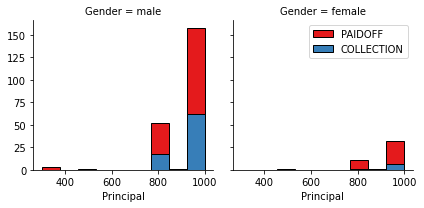

In [307]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

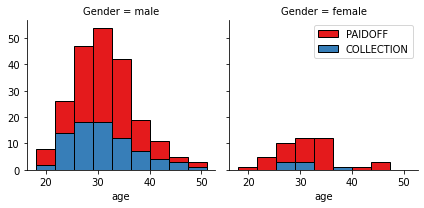

In [308]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


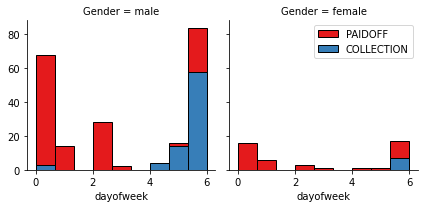

In [309]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [310]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [311]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [312]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [313]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [314]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [315]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [316]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [317]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [318]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [319]:
#1. Import libraries

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

In [320]:
#2. Split data

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split( X, y, test_size=0.2, random_state=42)

In [321]:
### function to finding best k for KNN. 

def find_best_k(maxNeighbors):
    error_rate = []

    for i in range(1, maxNeighbors):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train_knn, y_train_knn)
        pred_i = knn.predict(X_test_knn)
        error_rate.append(np.mean(pred_i != y_test_knn))
        best_k = np.argmin(error_rate) + 1
        lowest_error = np.min(error_rate)
                                                    
    return {"best_k": best_k,"lowest_error":lowest_error, "error_rate": error_rate}


In [322]:
### best k within (1, 10)
find_best_k(10).get('best_k')

3

Text(0, 0.5, 'Error Rate')

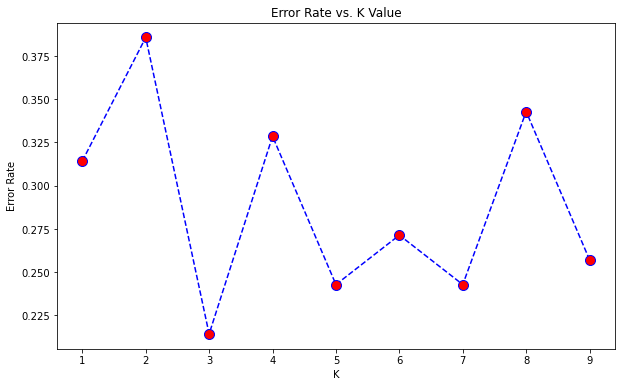

In [323]:
### Plot error rate graphs in terms of k

plt.figure(figsize=(10,6))
plt.plot(range(1,10),find_best_k(10).get('error_rate'),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [324]:
print( "The best accuracy is", 1 - find_best_k(10).get('lowest_error') , "with k=", find_best_k(10).get('best_k') )

The best accuracy is 0.7857142857142857 with k= 3


In [325]:
#3. Define and fit Classifier

knn_classifier = KNeighborsClassifier(n_neighbors=find_best_k(10).get('best_k'))
knn_classifier.fit(X_train_knn, y_train_knn)


KNeighborsClassifier(n_neighbors=3)

In [326]:
#4. Predict test set

y_pred_knn = knn_classifier.predict(X_test_knn)

In [327]:
#5. Performance metrics

y_pred_knn = knn_classifier.predict(X_test_knn)
knn_score_testset = accuracy_score(y_test_knn, y_pred_knn)
print('KNN accuracy score of test set: ', knn_score_testset)

knn_f1_score = f1_score(y_test_knn, y_pred_knn, average='weighted') 
print('KNN F1_score of test set: ', knn_f1_score)

knn_jaccard_score = jaccard_score(y_test_knn, y_pred_knn, pos_label="PAIDOFF") 
print('KNN jaccard of test set: ', knn_f1_score)

KNN accuracy score of test set:  0.7857142857142857
KNN F1_score of test set:  0.7826941986234022
KNN jaccard of test set:  0.7826941986234022


In [328]:
#6. etc (crosstab, confusion matrix, ...)

pd.crosstab(y_test_knn, y_pred_knn)
print(confusion_matrix(y_test_knn,y_pred_knn))
print(classification_report(y_test_knn,y_pred_knn))

[[ 6  8]
 [ 7 49]]
              precision    recall  f1-score   support

  COLLECTION       0.46      0.43      0.44        14
     PAIDOFF       0.86      0.88      0.87        56

    accuracy                           0.79        70
   macro avg       0.66      0.65      0.66        70
weighted avg       0.78      0.79      0.78        70



# Decision Tree


In [329]:
#1. Import libraries

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score

In [330]:
#2. Split data

from sklearn.model_selection import train_test_split
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split( X, y, test_size=0.3, random_state=42)

In [138]:
#3. Define and fit Classifier

dt_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt_classifier.fit(X_train_dt, y_train_dt)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [141]:
#4. Predict test set

y_pred_dt = dt_classifier.predict(X_test_dt)

In [331]:
#5. Performance metrics

dt_score = accuracy_score(y_test_dt, y_pred_dt)
print('DT score of train set: ', dt_score)

dt_f1_score = f1_score(y_test_dt, y_pred_dt, average='weighted') 
print('DT F1_score of test set: ', dt_f1_score)

dt_jaccard_score = jaccard_score(y_test_dt, y_pred_dt, pos_label="PAIDOFF") 
print('DT jaccard of test set: ', dt_jaccard_score)

DT score of train set:  0.6634615384615384
DT F1_score of test set:  0.6753403828875526
DT jaccard of test set:  0.6391752577319587


In [332]:
#6. etc (crosstab, confusion matrix, ...)

pd.crosstab(y_test_dt, y_pred_dt)
print(confusion_matrix(y_test_dt,y_pred_dt))
print(classification_report(y_test_dt,y_pred_dt))

[[ 7 15]
 [20 62]]
              precision    recall  f1-score   support

  COLLECTION       0.26      0.32      0.29        22
     PAIDOFF       0.81      0.76      0.78        82

    accuracy                           0.66       104
   macro avg       0.53      0.54      0.53       104
weighted avg       0.69      0.66      0.68       104



# Support Vector Machine


In [333]:
#1. Import libraries

from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score

In [335]:
#2. Split data

from sklearn.model_selection import train_test_split
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size = 0.20)

In [336]:
#3. Define and fit Classifier

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_svm, y_train_svm)

SVC(kernel='linear')

In [337]:
#4. Predict test set

y_pred_svm = svm_classifier.predict(X_test_svm)

In [338]:
#5. Performance metrics

svm_score = accuracy_score(y_test_svm, y_pred_svm)
print('SVM score of train set: ', svm_score)

svm_f1_score = f1_score(y_test_svm, y_pred_svm, average='weighted') 
print('SVM F1_score of test set: ', svm_f1_score)

svm_jaccard_score = jaccard_score(y_test_svm, y_pred_svm, pos_label="PAIDOFF") 
print('SVM jaccard of test set: ', svm_jaccard_score)

SVM score of train set:  0.7714285714285715
SVM F1_score of test set:  0.671889400921659
SVM jaccard of test set:  0.7714285714285715


In [196]:
#6. etc (crosstab, confusion matrix, ...)

pd.crosstab(y_test_svm, y_pred_svm)
print(confusion_matrix(y_test_svm,y_pred_svm))
print(classification_report(y_test_svm,y_pred_svm))

[[ 1 15]
 [ 0 54]]
              precision    recall  f1-score   support

  COLLECTION       1.00      0.06      0.12        16
     PAIDOFF       0.78      1.00      0.88        54

    accuracy                           0.79        70
   macro avg       0.89      0.53      0.50        70
weighted avg       0.83      0.79      0.70        70



# Logistic Regression


In [258]:
#1. Import libraries

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss

In [288]:
#2. Split data
from sklearn.model_selection import train_test_split 
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.2, random_state=42)

In [289]:
#3. Define and fit Classifier

logreg = LogisticRegression()
logreg.fit(X_train_lr, y_train_lr)


LogisticRegression()

In [292]:
#4. Predict test set

y_pred_lr = logreg.predict(X_test_lr)

In [297]:
#5. Performance metrics

lr_score = accuracy_score(y_test_lr, y_pred_lr)
print('LR score of train set: ', lr_score)

lr_f1_score = f1_score(y_test_lr, y_pred_lr, average='weighted') 
print('LR F1_score of test set: ', lr_f1_score)

lr_jaccard_score = jaccard_score(y_test_lr, y_pred_lr, pos_label="PAIDOFF") 
print('LR jaccard of test set: ', lr_jaccard_score)

lr_pred = logreg.predict_proba(X_test_lr)
lr_logloss = log_loss(y_test_lr, lr_pred)
print('LR logloss of test set: ', lr_logloss)


LR score of train set:  0.7
LR F1_score of test set:  0.695771878072763
LR jaccard of test set:  0.6865671641791045
LR logloss of test set:  0.514567222723989


In [294]:
#6. etc (crosstab, confusion matrix, ...)

pd.crosstab(y_test_lr, y_pred_lr)
print(confusion_matrix(y_test_lr,y_pred_lr))
print(classification_report(y_test_lr,y_pred_lr))

[[ 3 11]
 [10 46]]
              precision    recall  f1-score   support

  COLLECTION       0.23      0.21      0.22        14
     PAIDOFF       0.81      0.82      0.81        56

    accuracy                           0.70        70
   macro avg       0.52      0.52      0.52        70
weighted avg       0.69      0.70      0.70        70



# Model Evaluation using Test set


In [265]:
# 1. Import Libraries
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [266]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-03-21 14:59:08--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-03-21 14:59:09 (185 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [267]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [268]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


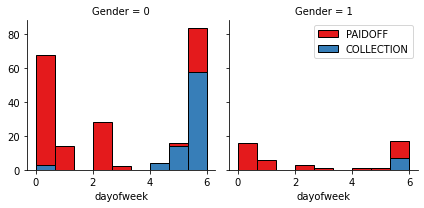

In [269]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [270]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [271]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
0       PAIDOFF        0.731293
        COLLECTION     0.268707
1       PAIDOFF        0.865385
        COLLECTION     0.134615
Name: loan_status, dtype: float64

In [272]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [273]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [274]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [275]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [276]:
X_test_set = Feature
X_test_set[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [277]:
y_test_set = df['loan_status'].values
y_test_set[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [278]:
X_test_set= preprocessing.StandardScaler().fit(X_test_set).transform(X_test_set)
X_test_set[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [339]:
#KNN

y_pred_knn_test = knn_classifier.predict(X_test_set)

knn_score_testset = accuracy_score(y_test_set, y_pred_knn_test)
print('KNN accuracy score of test set: ', knn_score_testset)

knn_f1_score_test = f1_score(y_test_set, y_pred_knn_test, average='weighted') 
print('KNN F1_score of test set: ', knn_f1_score_test)

knn_jaccard_score_test = jaccard_score(y_test_set, y_pred_knn_test, pos_label="PAIDOFF") 
print('KNN jaccard of test set: ', knn_jaccard_score_test)


KNN accuracy score of test set:  0.8208092485549133
KNN F1_score of test set:  0.8169691485938259
KNN jaccard of test set:  0.7905405405405406


In [341]:
#DT
y_pred_dt_test = dt_classifier.predict(X_test_set)

dt_score_test = accuracy_score(y_test_set, y_pred_dt_test)
print('DT score of train set: ', dt_score_test)

dt_f1_score_test = f1_score(y_test_set, y_pred_dt_test, average='weighted') 
print('DT F1_score of test set: ', dt_f1_score_test)

dt_jaccard_score_test = jaccard_score(y_test_set, y_pred_dt_test, pos_label="PAIDOFF") 
print('DT jaccard of test set: ', dt_jaccard_score_test)




DT score of train set:  0.8323699421965318
DT F1_score of test set:  0.8368423415773065
DT jaccard of test set:  0.7935943060498221


In [281]:
#SVM
y_pred_svm_test = svm_classifier.predict(X_test_set)

svm_score_test = accuracy_score(y_test_set, y_pred_svm_test)
print('SVM score of train set: ', svm_score_test)

svm_f1_score_test = f1_score(y_test_set, y_pred_svm_test, average='weighted') 
print('SVM F1_score of test set: ', svm_f1_score_test)

svm_jaccard_score_test = jaccard_score(y_test_set, y_pred_svm_test, pos_label="PAIDOFF") 
print('SVM jaccard of test set: ', svm_jaccard_score_test)

SVM score of train set:  0.7514450867052023
SVM F1_score of test set:  0.6448043648295465
SVM jaccard of test set:  0.7514450867052023


In [298]:
#LR
y_pred_lr_test = logreg.predict(X_test_set)


lr_score_test = accuracy_score(y_test_set, y_pred_lr_test)
print('LR score of train set: ', lr_score_test)

lr_f1_score_test = f1_score(y_test_set, y_pred_lr_test, average='weighted') 
print('LR F1_score of test set: ', lr_f1_score_test)

lr_jaccard_score_test = jaccard_score(y_test_set, y_pred_lr_test, pos_label="PAIDOFF") 
print('LR jaccard of test set: ', lr_jaccard_score_test)

lr_pred_test = logreg.predict_proba(X_test_set)
lr_logloss_test = log_loss(y_test_set, lr_pred_test)
print('LR logloss of test set: ', lr_logloss_test)


LR score of train set:  0.7485549132947977
LR F1_score of test set:  0.7296998146993409
LR jaccard of test set:  0.7264150943396226
LR logloss of test set:  0.43678083247962224


In [299]:
alg_lst = ['KNN', 'Decision Tree', 'SVM', 'LoisticRegression']
Jaccard_lst = [knn_jaccard_score_test, dt_jaccard_score_test, svm_jaccard_score_test, lr_jaccard_score_test]
F1_lst = [knn_f1_score_test, dt_f1_score_test, svm_f1_score_test, lr_f1_score_test]
LogLoss_lst = ['NA', 'NA', 'NA', lr_logloss_test]

df = pd.DataFrame(list(zip(alg_lst, Jaccard_lst, F1_lst, LogLoss_lst)),
              columns=['Algorithm','Jaccard', 'F1-score', 'LogLoss'])

df.set_index('Algorithm', inplace = True)
df

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.790541,0.816969,NA
Decision Tree,0.793594,0.836842,NA
SVM,0.751445,0.644804,NA
LoisticRegression,0.726415,0.729700,0.436781


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
